### Getting started with Backtrader
This is part of the KE5207 project assignment: GA-Fuzzy System for
Trading Crude Palm Oil Futures

### Setup the trading rules and platform here

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pylab as pylab
import csv

import pytz
import random
from os import listdir
from os.path import isfile, join

import skfuzzy as fuzz
from skfuzzy import control as ctrl
import math

In [2]:
def getFilesAndNames(dirpath):
    ''' Return only the Futures files from the directory'''
    onlyfiles = []
    for f in listdir(dirpath):
        fullpath = join(dirpath, f)
        if isfile(fullpath) and f.startswith("F"):
            onlyfiles.append((fullpath,f.split(".")[0]))
    #print (onlyfiles)
    return onlyfiles

#getFilesAndNames(os.getcwd() + "\\Data\\")

In [3]:
# setup data
def setup_multiple_data(bt, cerebro):
    import os
    modpath = os.getcwd() + "\\Data\\Test\\"
    datalist = getFilesAndNames(modpath)
    
    for i in range(len(datalist)):
        df = pd.read_csv(datalist[i][0])
        start_test = datetime.datetime.strptime(df['DateTime'][0], "%d/%m/%Y %H:%M")
        end_test = datetime.datetime.strptime(df['DateTime'][len(df)-1], "%d/%m/%Y %H:%M")
        
        # setup the data path
        #datafile = "FCPO_6_years_NUS.xlsx"
        data = bt.feeds.GenericCSVData(
            dataname=datalist[i][0],
            fromdate= start_test,
            todate= end_test,
            nullvalue=0.0,
            dtformat=('%d/%m/%Y %H:%M'),
            tz = pytz.timezone('Asia/Jakarta'),
            datetime=2,
            high=4,
            low=5,
            open=3,
            close=6,
            volume=7
        )
        # Add the Data Feed to Cerebro
        cerebro.adddata(data, name=datalist[i][1])
        
        #print ("Added data source {}".format(datalist[i][0]))
        #if testmode:
        return 

In [4]:
def setup_platform(cerebro):
    ''' Setup the rules of engagement'''
    # Set our desired cash start, using MYR
    cerebro.broker.setcash(10000000.0)

    # Set the commission - max of 0.2% or RM30
    comminfo = CommInfo_Fut_Perc_Mult(
        commission=0.002,#,  # 0.2%
        #mult=1,
        margin = 4000
    )

    cerebro.broker.addcommissioninfo(comminfo)
    #cerebro.broker.setcommission(commission=0.001)

    
    # Add a FixedSize sizer according to the stake
    #cerebro.addsizer(bt.sizers.FixedSize, stake=1)

In [5]:
class CommInfo_Fut_Perc_Mult(bt.CommInfoBase):
    #params = (
    #  ('stocklike', False)#,  # Futures
      #('commtype', bt.CommInfoBase.COMM_PERC),  # Apply % Commission
      # ('percabs', False),  # pass perc as xx% which is the default
    #)

    def _getcommission(self, size, price, pseudoexec):
        return max(30, size * price * self.p.commission * self.p.mult)

In [6]:
def setup_plot():
    pylab.rcParams['figure.figsize'] = 45, 30  # that's default image size for this interactive session
    pylab.rcParams['font.family'] = 'sans-serif'
    pylab.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
    pylab.rcParams['font.serif'] = ['Bitstream Vera Sans']
    pylab.rcParams["font.size"] = "200"

    #plotter = Plotter()
    #back_tester.plot(plotter=plotter)

    #plor the result
    #plt.figure(figsize=(15,20))
    #cerebro.plot(style='candlestick', iplot=False)
    #imagefile = "test_strategy.png"
    #modpath = os.getcwd() + "\\"
    ##datapath = os.path.join(modpath, imagefile)
    #pylab.savefig(datapath)


### Visualise the data
Data exploration and check the trend for the test data.

In [7]:
import os
modpath = os.getcwd() + "\\Data\\Test\\"
datalist = getFilesAndNames(modpath)

df = pd.read_csv(datalist[1][0])


In [8]:
# Sort DataFrame by date
df = df.sort_values('DateTime')

# Double check the result
df.head()

,Date,Time,DateTime,Open,High,Low,Close,Volume
1893,20121001,10:30:00,01/10/2012 10:30,2508,2516,2508,2516,6
1894,20121001,10:31:00,01/10/2012 10:31,2516,2516,2516,2516,4
1895,20121001,10:32:00,01/10/2012 10:32,2513,2513,2510,2510,31
1896,20121001,10:33:00,01/10/2012 10:33,2510,2510,2507,2507,39
1897,20121001,10:34:00,01/10/2012 10:34,2506,2506,2504,2504,30


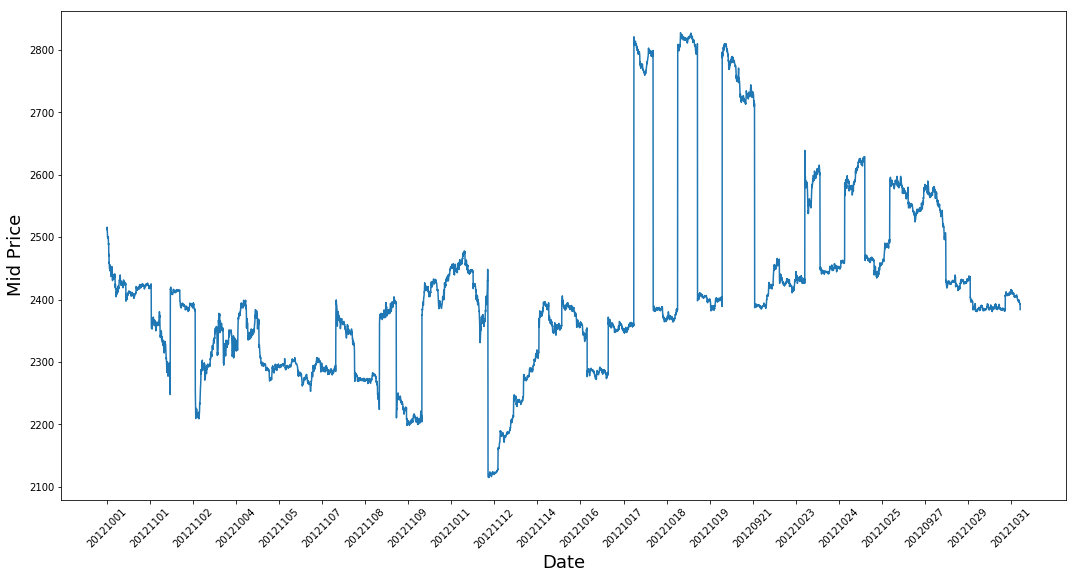

In [9]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

### Helper functions can be found here
This section contains the generic function used in this notebook.

In [10]:
# https://stackoverflow.com/questions/9489078/how-to-split-a-huge-csv-file-based-on-content-of-first-column
import csv
from itertools import groupby

def split_excel_to_csv():
    datafile = 'FCPO_6_years_NUS.csv'
    modpath = os.getcwd() + "\\Data\\"
    datapath = os.path.join(modpath, datafile)
    csv_header = 'Date,Time,DateTime,Open,High,Low,Close,Volume'
    reader = csv.reader(open(datapath))
    next(reader)
    for key, rows in groupby(reader,lambda row: row[0]):
        if key[-1] in ["1","2","3"]:
            outputpath = os.path.join(modpath+"//Test//","{}.csv".format(key))
        else:
            outputpath = os.path.join(modpath+"//Prod//","{}.csv".format(key))
        with open(outputpath, "w") as output:
            output.write(csv_header + "\n")
            for row in rows:
                row.pop(0) # remove the key
                output.write(",".join(row) + "\n")
                
#split_excel_to_csv()

In [11]:
def writeToCsv(filepath, data):
    ''' Generate a csv file which contains the seven fuzzy extent centroid value'''
    with open(filepath,'w') as f:
        #print ("max {} and min {}".format(max(data), min(data)))
        f.write(",".join(map(str,splitDataToSevenExtents(data))))
        
def loadFromCsv(filepath):
    ''' Load the previous stored fuzzy extent values from csv file'''
    with open(filepath, 'rt') as f:
        reader = csv.reader(f)
        return list(map(float,[r for r in reader][0]))

In [12]:
def splitDataToSevenExtents(data):
    ''' Split a list of array into seven parts meant for the fuzzy extent later
        Calculate the central point and also the std dev '''
    # get the max and min
    max_point = max(data)
    # split the positive into three parts
    min_point = min(data)
    # split the negative into three parts
    pos_part = 0
    if max_point > 0:
        pos_part = round(max_point / 3, 2)
    neg_part = 0
    if min_point < 0:
        neg_part = round(min_point / 3, 2)
    
    return [neg_part * 3,
            neg_part * 2,
            neg_part,
            0,
            pos_part,
            pos_part * 2,
            pos_part * 3]

In [13]:
def generateRandomRule():
    ''' generate one random rule'''
    inds = ['sma','ama','tma','tpma']
    m = np.array([10, 20, 50, 100, 150, 200])
    n = np.array([3,5,10,15,20])
    exts = ['VL','EL','L','M','H','VH','EH']
    neg = np.arange(-1,0,0.1)
    med = np.arange(-1,1,0.1)
    pos = np.arange(0,1,0.1)

    sel_ext = random.choice(exts)
    rec = 0
    if sel_ext in ['VL','EL','L']:
        rec = random.choice(neg)
    elif sel_ext in ['M']:
        rec = random.choice(med)
    else:
        rec = random.choice(pos)
        
    fast = random.choice(n)
    slow = random.choice(m[m>fast])

    return [random.choice(inds), fast, slow, sel_ext, rec]
    
#print (generateRandomRule())

def generateRandomIndividual():
    rules = []
    total_rules = 10
    for i in range(0,total_rules):
        rules.append(generateRandomRule())
    
    return np.array(rules)

#print (generateRandomIndividual())

def generateRandomPopulation():
    population = dict()
    for i in range(1,21):
        population[i] = {"individual":generateRandomIndividual()}
    return population

def modifyIndividual(ind):
    ind["newkey"] = 1

pop= generateRandomPopulation()

#modifyIndividual(pop[1])

#print (pop[1])
#for ind in pop.items():
#    print (ind)
#for rule in pop[1]["individual"]:
#    print (rule)
#pop[1]["rating"] = 10

#population = {0:{"ind":[]}}
#population[0]['ind'] = {}

### Building the fuzzy extents
Use the old data output the values to an external file to that the fuzzy extents models can be build later.

In [14]:
def buildFuzzySystem(arr, bShowPlot=False):
    '''Given an array of value, build and return a fuzzy system'''
    # New Antecedent/Consequent objects hold universe variables and membership functions

    fe = ctrl.Antecedent(np.arange(arr[0], arr[-2], 0.1), 'fe')
    rec= ctrl.Consequent(np.arange(-1, 1, 0.1), 'rec')

    rec["Neg"] = fuzz.pimf(rec.universe, -1, -1, -1, 0)
    rec["Med"] = fuzz.pimf(rec.universe, -1, 0, 0, 1)
    rec["Pos"] = fuzz.pimf(rec.universe, 0, 1, 1, 1)
    
    fe["EL"] = fuzz.pimf(fe.universe, arr[0], arr[0], arr[0],arr[1])
    fe["VL"] = fuzz.pimf(fe.universe, arr[0], arr[1], arr[1], arr[2])
    fe["L"] = fuzz.pimf(fe.universe, arr[1], arr[2], arr[2], arr[3])
    fe["M"] = fuzz.pimf(fe.universe, arr[2], arr[3], arr[3], arr[4])
    fe["H"] = fuzz.pimf(fe.universe, arr[3], arr[4], arr[4], arr[5])
    fe["VH"] = fuzz.pimf(fe.universe, arr[4], arr[5], arr[5], arr[6])
    fe["EH"] = fuzz.pimf(fe.universe, arr[5], arr[6], arr[6], arr[6])

    if bShowPlot:
        rec.view()
        fe.view()

    #build the rules
    rule1 = ctrl.Rule(fe["EL"] | fe["L"] | fe["VL"], rec["Neg"])
    rule2 = ctrl.Rule(fe["M"], rec["Med"])
    rule3 = ctrl.Rule(fe["EH"] | fe["H"] | fe["VH"], rec["Pos"])
    
    ctrl_sys = ctrl.ControlSystem([rule1, rule2, rule3])
    ctrl_instance = ctrl.ControlSystemSimulation(ctrl_sys)
    
    return ctrl_instance, fe, rec

In [15]:
def getFuzzyOutput(ctrl_instance, fe, rec, input_val, bShowPlot=False):
    ''' Given the fuzzy system and the input value, compute and return the mf and the fuzzy extent'''

    ext = ""
    rec = 0
    ants = []
    try:
        ctrl_instance.input['fe'] = input_val
        ctrl_instance.compute()
        #rec.view(sim=ctrl_instance)


        if bShowPlot:
            rec.view(sim=ctrl_instance)
            fe.view(sim=ctrl_instance)

        #print (ctrl_instance.print_state())
        #print (ctrl_instance.input['fe'])

        ants = ctrl_instance.get_antecedents()
        
        #print (ants)
        ext = ""
        if ants is not None:
            ext = max(ants, key=ants.get)
            rec = ctrl_instance.output['rec']
    except:
        print("Input val:{}. fe:{}, rec:{}".format(input_val, fe, rec))
        print("Unexpected error:", sys.exc_info()[0])
        #TODO: Handle this error properly
        #raise
    
    return (rec, ext)

### Setting up Custom indicators
Besides the standard simple moving average, we also need to setup:
1. Adaptive moving average
1. Typical Price moving average
1. Triangular moving average

In [16]:
class TypicalPriceMovingAverage(bt.Indicator):
    lines = ('tpma',)
    params = (('period', 20),)

    def __init__(self):
        self.addminperiod(self.params.period)

    def next(self):
        dataline = self.data.get(size=self.p.period)
        datasum = max(dataline) + min(dataline) + dataline[-1]
        self.lines.tpma[0] = datasum/3

### Defining strategies here
Creating a custom strategy to implement the FMAS crossover strategy.

In [26]:
class FMASCrossOver(bt.Strategy):
    """A simple moving average crossover strategy; crossing of a fast and slow moving average generates buy/sell
       signals"""
    params = {"individual":[],
              "filePath": "",
              "bDebug":False, #debug printout mode
              "bFuzzyPlot": False, #show fuzzy plot
              "bGenMaDiffFiles": False, #generate ma diff files for fuzzy extent building
              "bGetRating": False} #get overall rating for individual
    
    def getWritePath(self, ind_type, fast, slow):
        modpath = os.getcwd() + "\\Data\\"
        filename = "{}_{}_{}.csv".format(ind_type, fast, slow)
        filepath = os.path.join(modpath +"\\Model\\", filename)
        return filepath
        
    def getFuzzyModel(self, ind_type, fast, slow, bShowPlot = False):
        filepath = self.getWritePath(ind_type, fast, slow)        
        farr = loadFromCsv(filepath)       
        fuzsys, fe, rec = buildFuzzySystem(farr, bShowPlot=bShowPlot)
        return fuzsys, fe, rec

    def getFuzzyPosition(self, fuzsys, fe, rec, diffval, bShowPlot = False):
        mf, ext = getFuzzyOutput(fuzsys, fe, rec, diffval, bShowPlot=bShowPlot)
        return mf, ext
    
    def setIndicator(self, ma_type, period_val, ind_type, d):
        plottitle = "SlowMA: "
        #period_val = self.params.slow
        #ind_type = self.p.ind
        if ma_type == "fast":
            plottitle = "FastMA: "
         #   period_val = self.params.fast
            
        datafeed = self.getdatabyname(d)
        
        if self.p.bDebug:
            print ("ind:{}, ma type:{}, period:{}".format(ind_type, ma_type, period_val))
        
        ma = None
        if ind_type == 'sma':
            ma = bt.indicators.SMA(datafeed,      # The symbol for the moving average
                                   period=period_val,    # Fast moving average
                                   plotname=plottitle + d)

        elif ind_type == "ama":
            #ma = bt.indicators.KAMA(datafeed,      # The symbol for the moving average
            #                        period=period_val,    # Fast moving average
            #                        plotname=plottitle + d)
            ma = bt.talib.KAMA(datafeed, timeperiod=period_val, 
                               plotname=plottitle + d)


        elif ind_type == "tma":
            ma = bt.talib.TRIMA(datafeed,      # The symbol for the moving average
                               timeperiod=period_val,    # Fast moving average
                               plotname=plottitle + d)
        elif ind_type == "tpma":
            ma = TypicalPriceMovingAverage(datafeed,      # The symbol for the moving average
                                           period=period_val,    # Fast moving average
                                           plotname=plottitle + d)
        return ma

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        #TODO: Fix the datas[0] hardcoding later
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        """Initialize the strategy"""
        
        self.bStopRunning = False
        
        self.fastma = dict()
        self.slowma = dict()
        self.regime = dict()
        self.extent = dict()
        self.recommend = dict()
        
        # only use to build the fuzzy extent files
        self.madiff = dict()
        
        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        
        self.fuzsysModel = dict()
        self.feModel = dict()
        self.recModel = dict()
 
        self._addobserver(True, bt.observers.BuySell)    # CAUTION: Abuse of the method, I will change this in future code (see: https://community.backtrader.com/topic/473/plotting-just-the-account-s-value/4)
 
        for d in self.getdatanames():
 
            key = ""
            for rule in self.p.individual["individual"]:
                indtype = rule[0]
                fast = rule[1]
                slow = rule[2]
                extent = rule[3]
                recommend = rule[4]
                # The moving averages
                key = "{}_{}_{}_{}".format(d,indtype,fast,slow)
                self.fastma[key] = self.setIndicator("fast",int(fast), indtype,d)
                self.slowma[key] = self.setIndicator("slow",int(slow), indtype,d)
                self.madiff[key] = []
                #ma_type, period_val, ind_type, d
                
                # Get the regime
                self.regime[key] = self.fastma[key] - self.slowma[key]    # Positive when bullish
                self.extent[key] = extent
                self.recommend[key] = float(recommend)               
                self.fuzsysModel[key], self.feModel[key], self.recModel[key] \
                    = self.getFuzzyModel(indtype,fast,slow, bShowPlot=self.p.bFuzzyPlot)
            
    def next(self):
        #skip the rest of the data after we can get the rating
        if self.bStopRunning:
            return
        
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return
        
        #Loop through each data feed
        for i, d in enumerate(self.datas):
            dt, dn = self.datetime.date(), d._name
            pos = self.getposition(d).size
            
            key = ""
            ratings = []
            #loop through each rules within this individual
            for rule in self.p.individual["individual"]:
                key = "{}_{}_{}_{}".format(dn,rule[0],rule[1],rule[2])
            
                # for generate ma diff files, we want to collect all the ma diff for a particular key
                if self.p.bGenMaDiffFiles:
                    self.madiff[key].append(self.regime[key][0])
                    #self.log("Regime: {}".format(self.regime[dn][0]))                 
                else:
                    mf,ext = self.getFuzzyPosition(self.fuzsysModel[key], self.feModel[key], self.recModel[key], 
                                                   self.regime[key][0], bShowPlot=self.p.bFuzzyPlot)
                    # get the fe and recommended value based on past data
                    # check if the fe are the same 
                    rating = 0
                    if(ext == self.extent[key]):
                        # if it is then calculate the overall rating per rule
                        rating = mf * self.recommend[key]
                        ratings.append(rating)
                        if self.p.bDebug:
                            print ("Rating:{} and extent:{} for key:{}".format(rating,ext, key))
                        
            #calculate the rating at individual level
            avg_rating = np.average(ratings)
            if not math.isnan(avg_rating) and self.p.bDebug:
                print ("Average rating:{} and pos is:{} for key:{}".format(avg_rating, pos, key))


            # for bGetRating mode, we just want to get the rating for the individual and exit
            if (avg_rating > 0 or avg_rating < 0) and self.p.bGetRating:
                self.p.individual["rating"] = avg_rating
                print ("EXITING THE PROGRAM")
                self.bStopRunning = True
            else:
                if avg_rating > 0:    # A buy signal
                    # BUY, BUY, BUY!!! (with default parameters)
                    self.log('%s BUY CREATE, %.2f with volume %.2f' % (dn, d.high[0], d.volume[0]), 
                             dt=d.datetime.date(0))

                    # Keep track of the created order to avoid a 2nd order
                    self.order = self.buy(data=d, price=d.high[0], size = (self.stats.broker.cash[0]/d.high[0])*avg_rating)

                elif avg_rating < 0:    # A sell signal
                        # SELL, SELL, SELL!!! (with all possible default parameters)
                        self.log('%s SELL CREATE, %.2f with volume %.2f' % (dn, d.low[0], d.volume[0]), 
                                 dt=d.datetime.date(0))

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.sell(data=d, price=d.low[0], size = (self.stats.broker.cash[0]/d.low[0])*avg_rating)

                    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, Size: %.2f, Price: %.2f, Cost: %.2f, Comm %.2f, Portfolio Value: %.2f, Cash: %.2f' %
                    (order.executed.size,
                     order.executed.price,
                     order.executed.value,
                     order.executed.comm,
                     self.stats.broker.value[0],
                     self.stats.broker.cash[0]))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            elif order.issell():
                self.log('SELL EXECUTED, Size: %.2f, Price: %.2f, Cost: %.2f, Comm %.2f, Portfolio Value: %.2f, Cash: %.2f' %
                         (order.executed.size,
                          order.executed.price,
                          order.executed.value,
                          order.executed.comm,
                         self.stats.broker.value[0],
                         self.stats.broker.cash[0]))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None
    
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
        
    def stop(self):
        if self.p.bGetRating:
            return
        
        if self.p.bGenMaDiffFiles:
            for i, d in enumerate(self.datas):
                dt, dn = self.datetime.date(), d._name

                key = ""
                #loop through each rules within this individual
                for rule in self.p.individual["individual"]:
                    key = "{}_{}_{}_{}".format(dn,rule[0],rule[1],rule[2])

                    writePath = self.getWritePath(rule[0],rule[1],rule[2])
                    writeToCsv(writePath, self.madiff[key])
                    #self.log(len(self.madiff_arr))
            return
        
        # else get the cash for a normal trade
        if "rating" not in self.p.individual.keys():
            self.p.individual['rating'] = 0
        # add the final profit value to the individual
        self.p.individual['profit'] = self.stats.broker.value[0]
        
        

### Main function goes here
We'll process one individual per run.

In [21]:
#from report import Cerebro

#if __name__ == '__main__':
def main(individual, bGetRating= False, plotFileName = "", bDebug=False):
    # Create a cerebro entity
    cerebro = bt.Cerebro()
    
    # get path
    modpath = os.getcwd() + "\\Data\\"
    #filename = "{}_{}_{}.csv".format(ind_type, fast, slow)
    #filepath = os.path.join(modpath +"\\Model\\", filename)
    
    # Add a strategy
    cerebro.addstrategy(FMASCrossOver, individual=individual, bGetRating=bGetRating,bDebug=bDebug)

    # Create a Data Feed
    setup_multiple_data(bt, cerebro)

    setup_platform(cerebro)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Plot the result
    if not plotFileName == "":
        imagefile = "graph{}.png".format(plotFileName)
        datapath = os.path.join(modpath+"\\Graph\\", imagefile)
        cerebro.plot(style='candlestick', iplot=False, ytight=True, subplot=False, path=datapath)

### Strategy starts here
1. Generate the initial population. Randomly generate 20 individuals. Each individual contains 10 rules in accordance with the rules set.
1. Calculate the fuzzy moving averages in the training period. Calculate the differences between two moving averages in the training period and the previous training period using the moving average method and the length of two moving averages that the rule provides. 
1. Next, obtain the membership function according to the moving average differences of the previous training period. 
1. Calculate the rating level according to the moving average differences of this training period, the membership function, and the recommend values that the individual provides. Because every individual provides a set of recommend values, there are ultimately 20 sets of rating levels.

Starting Portfolio Value: 10000000.00
ind:tma, ma type:fast, period:3
ind:tma, ma type:slow, period:100
ind:ama, ma type:fast, period:15
ind:ama, ma type:slow, period:150
ind:sma, ma type:fast, period:10
ind:sma, ma type:slow, period:20
ind:sma, ma type:fast, period:10
ind:sma, ma type:slow, period:100
ind:tma, ma type:fast, period:20
ind:tma, ma type:slow, period:50
ind:tpma, ma type:fast, period:10
ind:tpma, ma type:slow, period:100
ind:sma, ma type:fast, period:15
ind:sma, ma type:slow, period:100
ind:tma, ma type:fast, period:20
ind:tma, ma type:slow, period:50
ind:ama, ma type:fast, period:3
ind:ama, ma type:slow, period:20
ind:tma, ma type:fast, period:5
ind:tma, ma type:slow, period:200
Rating:-0.050802021488323 and extent:M for key:FCPO0112_sma_10_100
Rating:-0.0002213709744255122 and extent:M for key:FCPO0112_ama_3_20
Average rating:-0.025511696231374257 and pos is:0 for key:FCPO0112_tma_5_200
EXITING THE PROGRAM
Final Portfolio Value: 10000000.00


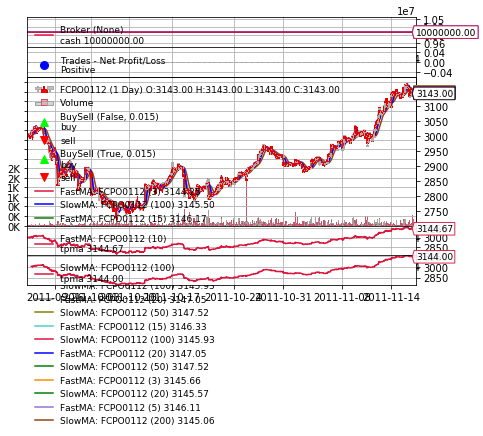

Starting Portfolio Value: 10000000.00
ind:sma, ma type:fast, period:5
ind:sma, ma type:slow, period:20
ind:tpma, ma type:fast, period:20
ind:tpma, ma type:slow, period:150
ind:ama, ma type:fast, period:15
ind:ama, ma type:slow, period:150
ind:tma, ma type:fast, period:3
ind:tma, ma type:slow, period:100
ind:ama, ma type:fast, period:5
ind:ama, ma type:slow, period:10
ind:sma, ma type:fast, period:5
ind:sma, ma type:slow, period:50
ind:ama, ma type:fast, period:3
ind:ama, ma type:slow, period:200
ind:tma, ma type:fast, period:15
ind:tma, ma type:slow, period:100
ind:tpma, ma type:fast, period:10
ind:tpma, ma type:slow, period:20
ind:ama, ma type:fast, period:20
ind:ama, ma type:slow, period:100
Rating:0.03233370472222617 and extent:M for key:FCPO0112_tma_3_100
Rating:0.016522233275132376 and extent:M for key:FCPO0112_tma_15_100
Average rating:0.024427968998679273 and pos is:0 for key:FCPO0112_ama_20_100
EXITING THE PROGRAM
Final Portfolio Value: 10000000.00


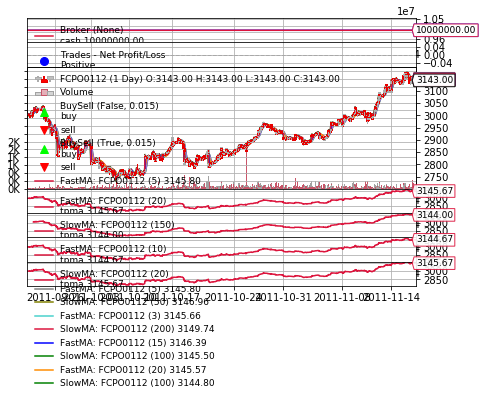

Starting Portfolio Value: 10000000.00
ind:tma, ma type:fast, period:3
ind:tma, ma type:slow, period:20
ind:sma, ma type:fast, period:15
ind:sma, ma type:slow, period:150
ind:tma, ma type:fast, period:10
ind:tma, ma type:slow, period:200
ind:ama, ma type:fast, period:3
ind:ama, ma type:slow, period:150
ind:sma, ma type:fast, period:5
ind:sma, ma type:slow, period:50
ind:ama, ma type:fast, period:5
ind:ama, ma type:slow, period:10
ind:tma, ma type:fast, period:15
ind:tma, ma type:slow, period:100
ind:tpma, ma type:fast, period:15
ind:tpma, ma type:slow, period:200
ind:tpma, ma type:fast, period:3
ind:tpma, ma type:slow, period:10
ind:tma, ma type:fast, period:20
ind:tma, ma type:slow, period:150
Rating:0.0 and extent:H for key:FCPO0112_tma_10_200
Rating:0.2522204841648038 and extent:H for key:FCPO0112_ama_5_10
Rating:0.0 and extent:H for key:FCPO0112_tma_20_150
Average rating:0.08407349472160126 and pos is:0 for key:FCPO0112_tma_20_150
EXITING THE PROGRAM
Final Portfolio Value: 10000000.

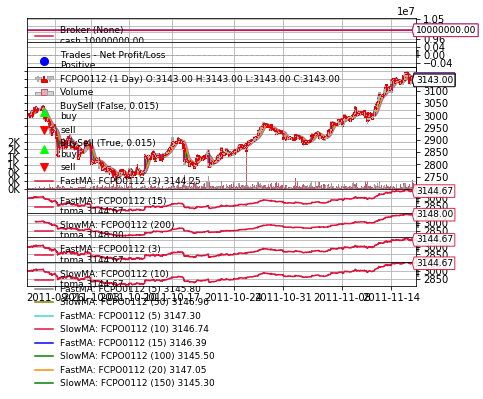

Starting Portfolio Value: 10000000.00
ind:tpma, ma type:fast, period:20
ind:tpma, ma type:slow, period:100
ind:tma, ma type:fast, period:15
ind:tma, ma type:slow, period:200
ind:tma, ma type:fast, period:5
ind:tma, ma type:slow, period:20
ind:tma, ma type:fast, period:3
ind:tma, ma type:slow, period:20
ind:sma, ma type:fast, period:20
ind:sma, ma type:slow, period:150
ind:sma, ma type:fast, period:10
ind:sma, ma type:slow, period:50
ind:tma, ma type:fast, period:10
ind:tma, ma type:slow, period:100
ind:sma, ma type:fast, period:20
ind:sma, ma type:slow, period:50
ind:tpma, ma type:fast, period:20
ind:tpma, ma type:slow, period:200
ind:ama, ma type:fast, period:20
ind:ama, ma type:slow, period:200
Rating:-8.23764347959531e-05 and extent:M for key:FCPO0112_sma_10_50
Average rating:-8.23764347959531e-05 and pos is:0 for key:FCPO0112_ama_20_200
EXITING THE PROGRAM
Final Portfolio Value: 10000000.00


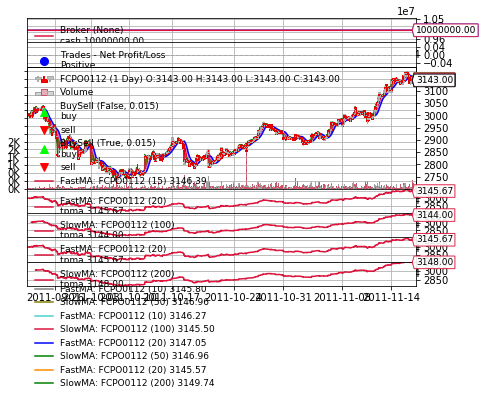

Starting Portfolio Value: 10000000.00
ind:sma, ma type:fast, period:10
ind:sma, ma type:slow, period:100
ind:tma, ma type:fast, period:15
ind:tma, ma type:slow, period:150
ind:ama, ma type:fast, period:15
ind:ama, ma type:slow, period:100
ind:sma, ma type:fast, period:15
ind:sma, ma type:slow, period:150
ind:sma, ma type:fast, period:10
ind:sma, ma type:slow, period:200
ind:ama, ma type:fast, period:20
ind:ama, ma type:slow, period:50
ind:ama, ma type:fast, period:3
ind:ama, ma type:slow, period:20
ind:tma, ma type:fast, period:10
ind:tma, ma type:slow, period:100
ind:tpma, ma type:fast, period:5
ind:tpma, ma type:slow, period:10
ind:tpma, ma type:fast, period:10
ind:tpma, ma type:slow, period:50
Rating:0.1030723050251597 and extent:H for key:FCPO0112_sma_15_150
Rating:0.015364985639768009 and extent:H for key:FCPO0112_ama_3_20
Rating:-0.0002921841784862738 and extent:M for key:FCPO0112_tpma_5_10
Rating:0.019059058138610557 and extent:M for key:FCPO0112_tpma_10_50
Average rating:0.0343

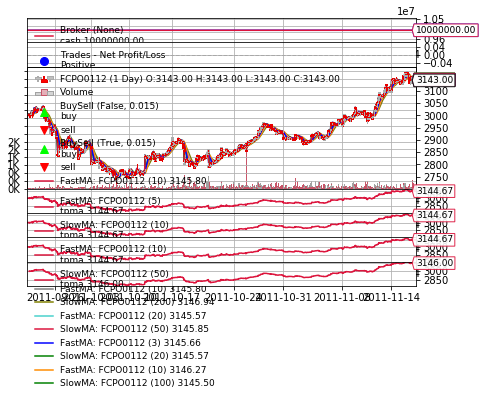

Starting Portfolio Value: 10000000.00
ind:ama, ma type:fast, period:5
ind:ama, ma type:slow, period:200
ind:tpma, ma type:fast, period:3
ind:tpma, ma type:slow, period:150
ind:sma, ma type:fast, period:5
ind:sma, ma type:slow, period:10
ind:ama, ma type:fast, period:20
ind:ama, ma type:slow, period:200
ind:tma, ma type:fast, period:15
ind:tma, ma type:slow, period:200
ind:ama, ma type:fast, period:3
ind:ama, ma type:slow, period:150
ind:sma, ma type:fast, period:5
ind:sma, ma type:slow, period:10
ind:tma, ma type:fast, period:20
ind:tma, ma type:slow, period:100
ind:tpma, ma type:fast, period:10
ind:tpma, ma type:slow, period:150
ind:tma, ma type:fast, period:5
ind:tma, ma type:slow, period:200
Rating:0.5578384865890416 and extent:H for key:FCPO0112_tpma_3_150
Average rating:0.5578384865890416 and pos is:0 for key:FCPO0112_tma_5_200
EXITING THE PROGRAM
Final Portfolio Value: 10000000.00


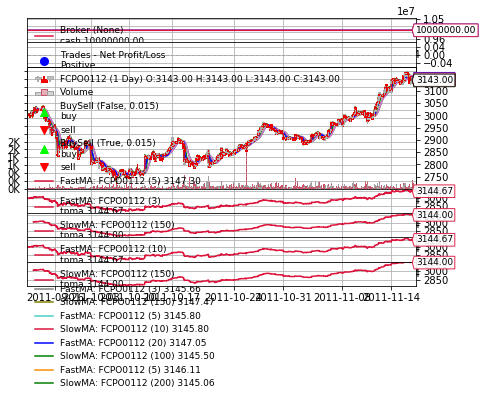

Starting Portfolio Value: 10000000.00
ind:tma, ma type:fast, period:10
ind:tma, ma type:slow, period:20
ind:tma, ma type:fast, period:20
ind:tma, ma type:slow, period:150
ind:tpma, ma type:fast, period:5
ind:tpma, ma type:slow, period:200
ind:tpma, ma type:fast, period:20
ind:tpma, ma type:slow, period:100
ind:ama, ma type:fast, period:5
ind:ama, ma type:slow, period:50
ind:tma, ma type:fast, period:5
ind:tma, ma type:slow, period:20
ind:sma, ma type:fast, period:3
ind:sma, ma type:slow, period:200
ind:sma, ma type:fast, period:5
ind:sma, ma type:slow, period:50
ind:ama, ma type:fast, period:3
ind:ama, ma type:slow, period:100
ind:sma, ma type:fast, period:5
ind:sma, ma type:slow, period:10
Rating:0.0024691908754483883 and extent:M for key:FCPO0112_tma_5_20
Rating:0.2892807343568087 and extent:H for key:FCPO0112_sma_3_200
Average rating:0.14587496261612853 and pos is:0 for key:FCPO0112_sma_5_10
EXITING THE PROGRAM
Final Portfolio Value: 10000000.00


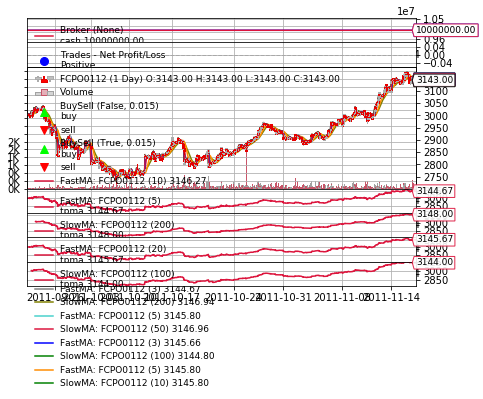

Starting Portfolio Value: 10000000.00
ind:tma, ma type:fast, period:3
ind:tma, ma type:slow, period:200
ind:tpma, ma type:fast, period:10
ind:tpma, ma type:slow, period:20
ind:tpma, ma type:fast, period:5
ind:tpma, ma type:slow, period:200
ind:sma, ma type:fast, period:10
ind:sma, ma type:slow, period:150
ind:sma, ma type:fast, period:5
ind:sma, ma type:slow, period:150
ind:tma, ma type:fast, period:5
ind:tma, ma type:slow, period:10
ind:sma, ma type:fast, period:5
ind:sma, ma type:slow, period:10
ind:tma, ma type:fast, period:20
ind:tma, ma type:slow, period:100
ind:tma, ma type:fast, period:3
ind:tma, ma type:slow, period:100
ind:ama, ma type:fast, period:20
ind:ama, ma type:slow, period:200
Rating:0.021411482989650638 and extent:M for key:FCPO0112_sma_5_150
Average rating:0.021411482989650638 and pos is:0 for key:FCPO0112_ama_20_200
EXITING THE PROGRAM
Final Portfolio Value: 10000000.00


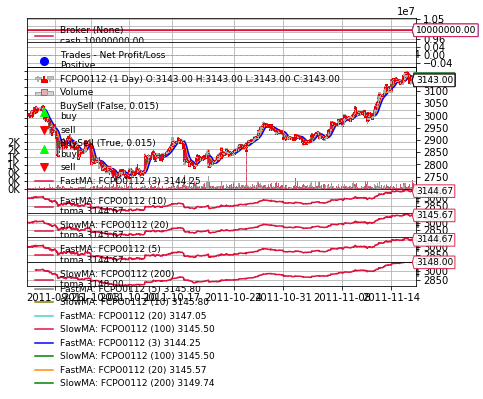

Starting Portfolio Value: 10000000.00
ind:tpma, ma type:fast, period:15
ind:tpma, ma type:slow, period:200
ind:tpma, ma type:fast, period:5
ind:tpma, ma type:slow, period:50
ind:tpma, ma type:fast, period:20
ind:tpma, ma type:slow, period:200
ind:tma, ma type:fast, period:20
ind:tma, ma type:slow, period:100
ind:tpma, ma type:fast, period:15
ind:tpma, ma type:slow, period:20
ind:sma, ma type:fast, period:3
ind:sma, ma type:slow, period:200
ind:tma, ma type:fast, period:20
ind:tma, ma type:slow, period:200
ind:tma, ma type:fast, period:15
ind:tma, ma type:slow, period:200
ind:sma, ma type:fast, period:10
ind:sma, ma type:slow, period:50
ind:tma, ma type:fast, period:5
ind:tma, ma type:slow, period:200
Rating:0.00040314355266716703 and extent:M for key:FCPO0112_tpma_15_20
Average rating:0.00040314355266716703 and pos is:0 for key:FCPO0112_tma_5_200
EXITING THE PROGRAM
Final Portfolio Value: 10000000.00


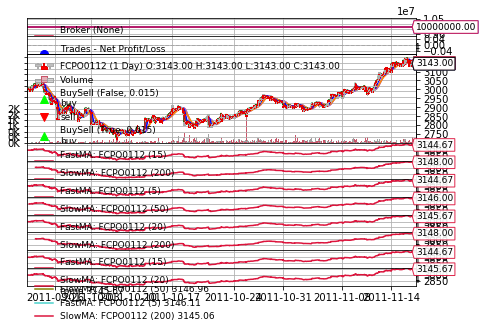

Starting Portfolio Value: 10000000.00
ind:tma, ma type:fast, period:10
ind:tma, ma type:slow, period:150
ind:sma, ma type:fast, period:15
ind:sma, ma type:slow, period:50
ind:tma, ma type:fast, period:20
ind:tma, ma type:slow, period:50
ind:tpma, ma type:fast, period:10
ind:tpma, ma type:slow, period:200
ind:sma, ma type:fast, period:3
ind:sma, ma type:slow, period:150
ind:sma, ma type:fast, period:10
ind:sma, ma type:slow, period:50
ind:tma, ma type:fast, period:10
ind:tma, ma type:slow, period:200
ind:ama, ma type:fast, period:5
ind:ama, ma type:slow, period:100
ind:sma, ma type:fast, period:5
ind:sma, ma type:slow, period:100
ind:tpma, ma type:fast, period:15
ind:tpma, ma type:slow, period:150
Rating:0.0010614522717671208 and extent:M for key:FCPO0112_sma_10_50
Rating:0.13738280697896224 and extent:H for key:FCPO0112_ama_5_100
Rating:0.12884419562398128 and extent:H for key:FCPO0112_tpma_15_150
Average rating:0.08909615162490354 and pos is:0 for key:FCPO0112_tpma_15_150
EXITING THE 

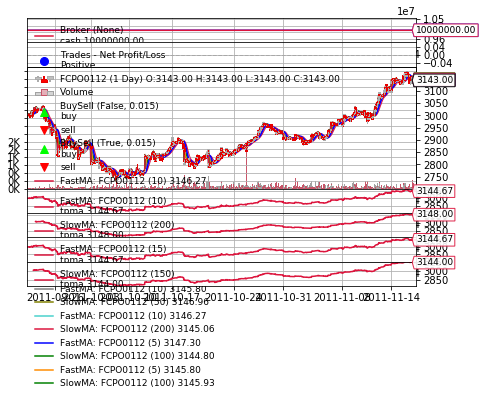

Starting Portfolio Value: 10000000.00
ind:ama, ma type:fast, period:20
ind:ama, ma type:slow, period:200
ind:tma, ma type:fast, period:20
ind:tma, ma type:slow, period:100
ind:ama, ma type:fast, period:10
ind:ama, ma type:slow, period:200
ind:ama, ma type:fast, period:15
ind:ama, ma type:slow, period:50
ind:ama, ma type:fast, period:10
ind:ama, ma type:slow, period:100
ind:tpma, ma type:fast, period:15
ind:tpma, ma type:slow, period:150
ind:ama, ma type:fast, period:15
ind:ama, ma type:slow, period:20
ind:sma, ma type:fast, period:3
ind:sma, ma type:slow, period:150
ind:tpma, ma type:fast, period:10
ind:tpma, ma type:slow, period:150
ind:ama, ma type:fast, period:10
ind:ama, ma type:slow, period:150
Rating:0.02605022029415546 and extent:H for key:FCPO0112_ama_15_50
Average rating:0.02605022029415546 and pos is:0 for key:FCPO0112_ama_10_150
EXITING THE PROGRAM
Final Portfolio Value: 10000000.00


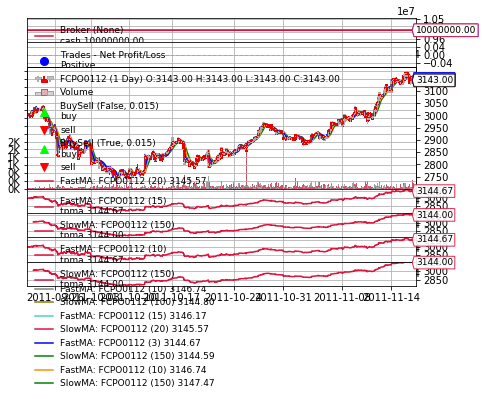

Starting Portfolio Value: 10000000.00
ind:sma, ma type:fast, period:3
ind:sma, ma type:slow, period:20
ind:tpma, ma type:fast, period:10
ind:tpma, ma type:slow, period:200
ind:tpma, ma type:fast, period:15
ind:tpma, ma type:slow, period:100
ind:tpma, ma type:fast, period:3
ind:tpma, ma type:slow, period:100
ind:sma, ma type:fast, period:5
ind:sma, ma type:slow, period:200
ind:sma, ma type:fast, period:5
ind:sma, ma type:slow, period:100
ind:sma, ma type:fast, period:20
ind:sma, ma type:slow, period:200
ind:sma, ma type:fast, period:3
ind:sma, ma type:slow, period:150
ind:tpma, ma type:fast, period:10
ind:tpma, ma type:slow, period:100
ind:sma, ma type:fast, period:15
ind:sma, ma type:slow, period:150
Rating:0.2564673943489945 and extent:H for key:FCPO0112_tpma_15_100
Rating:0.08655025791822986 and extent:H for key:FCPO0112_sma_5_100
Rating:0.24831701562101227 and extent:H for key:FCPO0112_sma_3_150
Average rating:0.19711155596274554 and pos is:0 for key:FCPO0112_sma_15_150
EXITING THE 

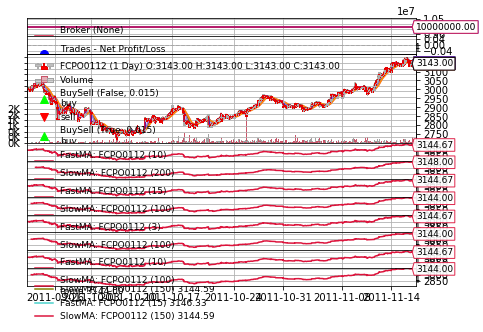

Starting Portfolio Value: 10000000.00
ind:ama, ma type:fast, period:5
ind:ama, ma type:slow, period:10
ind:ama, ma type:fast, period:3
ind:ama, ma type:slow, period:200
ind:tma, ma type:fast, period:3
ind:tma, ma type:slow, period:200
ind:tma, ma type:fast, period:10
ind:tma, ma type:slow, period:50
ind:sma, ma type:fast, period:10
ind:sma, ma type:slow, period:200
ind:ama, ma type:fast, period:15
ind:ama, ma type:slow, period:150
ind:sma, ma type:fast, period:20
ind:sma, ma type:slow, period:50
ind:ama, ma type:fast, period:10
ind:ama, ma type:slow, period:150
ind:tma, ma type:fast, period:5
ind:tma, ma type:slow, period:20
ind:ama, ma type:fast, period:20
ind:ama, ma type:slow, period:50
Rating:0.2625760167561425 and extent:VL for key:FCPO0112_ama_20_50
Average rating:0.2625760167561425 and pos is:0 for key:FCPO0112_ama_20_50
EXITING THE PROGRAM
Final Portfolio Value: 10000000.00


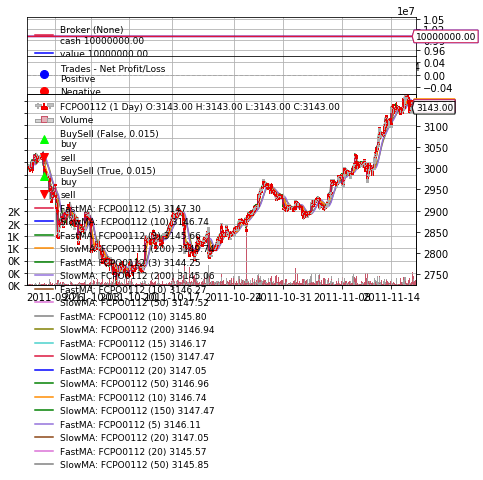

Starting Portfolio Value: 10000000.00
ind:tpma, ma type:fast, period:20
ind:tpma, ma type:slow, period:100
ind:sma, ma type:fast, period:15
ind:sma, ma type:slow, period:150
ind:tma, ma type:fast, period:20
ind:tma, ma type:slow, period:150
ind:ama, ma type:fast, period:5
ind:ama, ma type:slow, period:10
ind:sma, ma type:fast, period:5
ind:sma, ma type:slow, period:200
ind:sma, ma type:fast, period:20
ind:sma, ma type:slow, period:200
ind:sma, ma type:fast, period:20
ind:sma, ma type:slow, period:100
ind:tma, ma type:fast, period:10
ind:tma, ma type:slow, period:100
ind:sma, ma type:fast, period:5
ind:sma, ma type:slow, period:50
ind:tpma, ma type:fast, period:5
ind:tpma, ma type:slow, period:200
Rating:0.2585202236301837 and extent:H for key:FCPO0112_tpma_20_100
Rating:0.23552998214982734 and extent:H for key:FCPO0112_tma_20_150
Rating:-1.5891887452196904e-18 and extent:M for key:FCPO0112_sma_5_50
Average rating:0.16468340192667033 and pos is:0 for key:FCPO0112_tpma_5_200
EXITING THE 

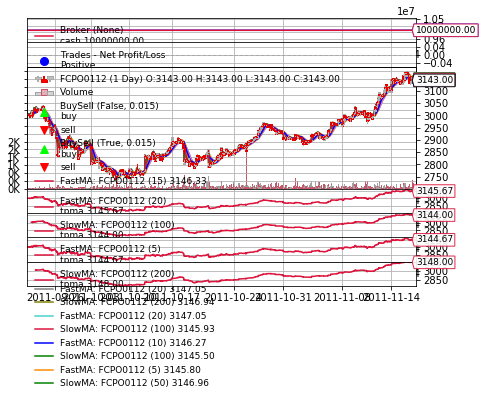

Starting Portfolio Value: 10000000.00
ind:sma, ma type:fast, period:15
ind:sma, ma type:slow, period:20
ind:tpma, ma type:fast, period:10
ind:tpma, ma type:slow, period:100
ind:ama, ma type:fast, period:20
ind:ama, ma type:slow, period:200
ind:sma, ma type:fast, period:20
ind:sma, ma type:slow, period:200
ind:tpma, ma type:fast, period:5
ind:tpma, ma type:slow, period:50
ind:tma, ma type:fast, period:5
ind:tma, ma type:slow, period:200
ind:sma, ma type:fast, period:3
ind:sma, ma type:slow, period:150
ind:tma, ma type:fast, period:3
ind:tma, ma type:slow, period:20
ind:ama, ma type:fast, period:5
ind:ama, ma type:slow, period:10
ind:tpma, ma type:fast, period:15
ind:tpma, ma type:slow, period:200
Rating:0.0549940055420268 and extent:M for key:FCPO0112_sma_3_150
Average rating:0.0549940055420268 and pos is:0 for key:FCPO0112_tpma_15_200
EXITING THE PROGRAM
Final Portfolio Value: 10000000.00


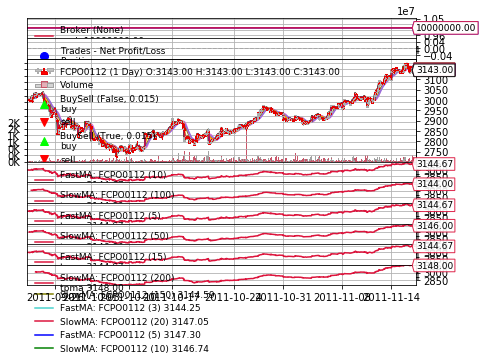

Starting Portfolio Value: 10000000.00
ind:tpma, ma type:fast, period:5
ind:tpma, ma type:slow, period:100
ind:tpma, ma type:fast, period:3
ind:tpma, ma type:slow, period:150
ind:sma, ma type:fast, period:20
ind:sma, ma type:slow, period:100
ind:sma, ma type:fast, period:10
ind:sma, ma type:slow, period:100
ind:ama, ma type:fast, period:15
ind:ama, ma type:slow, period:200
ind:tma, ma type:fast, period:3
ind:tma, ma type:slow, period:200
ind:tma, ma type:fast, period:3
ind:tma, ma type:slow, period:200
ind:ama, ma type:fast, period:15
ind:ama, ma type:slow, period:200
ind:sma, ma type:fast, period:10
ind:sma, ma type:slow, period:50
ind:sma, ma type:fast, period:15
ind:sma, ma type:slow, period:150
Rating:0.43387437845814353 and extent:H for key:FCPO0112_tpma_3_150
Rating:-5.491762319730209e-05 and extent:M for key:FCPO0112_sma_10_50
Average rating:0.2169097304174731 and pos is:0 for key:FCPO0112_sma_15_150
EXITING THE PROGRAM
Final Portfolio Value: 10000000.00


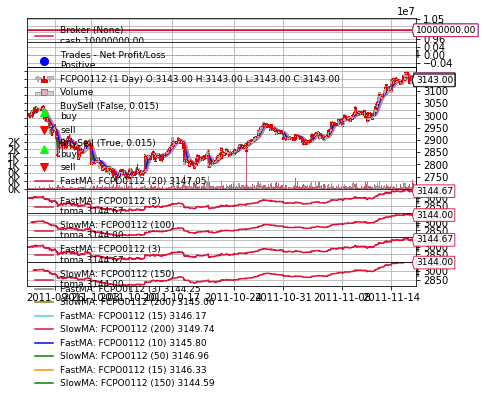

Starting Portfolio Value: 10000000.00
ind:tma, ma type:fast, period:15
ind:tma, ma type:slow, period:50
ind:ama, ma type:fast, period:5
ind:ama, ma type:slow, period:150
ind:ama, ma type:fast, period:3
ind:ama, ma type:slow, period:20
ind:sma, ma type:fast, period:20
ind:sma, ma type:slow, period:200
ind:ama, ma type:fast, period:15
ind:ama, ma type:slow, period:20
ind:sma, ma type:fast, period:20
ind:sma, ma type:slow, period:150
ind:sma, ma type:fast, period:20
ind:sma, ma type:slow, period:150
ind:tpma, ma type:fast, period:10
ind:tpma, ma type:slow, period:200
ind:sma, ma type:fast, period:5
ind:sma, ma type:slow, period:100
ind:ama, ma type:fast, period:15
ind:ama, ma type:slow, period:100
Rating:0.07682492819884004 and extent:H for key:FCPO0112_ama_3_20
Average rating:0.07682492819884004 and pos is:0 for key:FCPO0112_ama_15_100
EXITING THE PROGRAM
Final Portfolio Value: 10000000.00


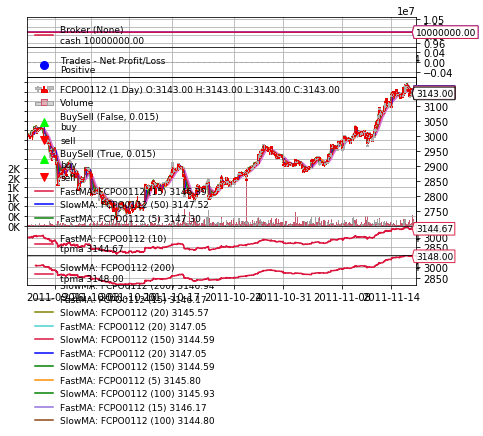

Starting Portfolio Value: 10000000.00
ind:tma, ma type:fast, period:3
ind:tma, ma type:slow, period:20
ind:tpma, ma type:fast, period:3
ind:tpma, ma type:slow, period:20
ind:ama, ma type:fast, period:3
ind:ama, ma type:slow, period:20
ind:tpma, ma type:fast, period:10
ind:tpma, ma type:slow, period:100
ind:tma, ma type:fast, period:20
ind:tma, ma type:slow, period:100
ind:tpma, ma type:fast, period:5
ind:tpma, ma type:slow, period:200
ind:tpma, ma type:fast, period:5
ind:tpma, ma type:slow, period:50
ind:tma, ma type:fast, period:5
ind:tma, ma type:slow, period:100
ind:sma, ma type:fast, period:15
ind:sma, ma type:slow, period:100
ind:ama, ma type:fast, period:15
ind:ama, ma type:slow, period:50
Rating:0.0 and extent:H for key:FCPO0112_tpma_5_200
Average rating:0.0 and pos is:0 for key:FCPO0112_ama_15_50
Rating:0.0 and extent:H for key:FCPO0112_tpma_5_200
Rating:0.06448514681001818 and extent:M for key:FCPO0112_tma_5_100
Average rating:0.03224257340500909 and pos is:0 for key:FCPO0112_

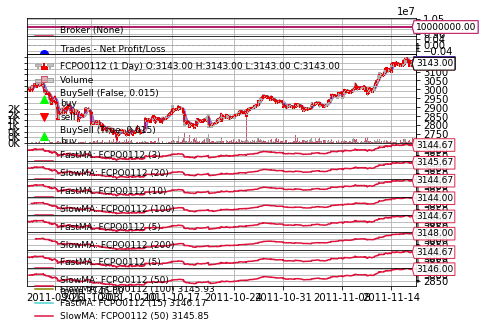

Starting Portfolio Value: 10000000.00
ind:ama, ma type:fast, period:15
ind:ama, ma type:slow, period:100
ind:tma, ma type:fast, period:10
ind:tma, ma type:slow, period:20
ind:tma, ma type:fast, period:3
ind:tma, ma type:slow, period:100
ind:sma, ma type:fast, period:3
ind:sma, ma type:slow, period:20
ind:tma, ma type:fast, period:20
ind:tma, ma type:slow, period:50
ind:tma, ma type:fast, period:5
ind:tma, ma type:slow, period:50
ind:sma, ma type:fast, period:3
ind:sma, ma type:slow, period:50
ind:tpma, ma type:fast, period:3
ind:tpma, ma type:slow, period:20
ind:tpma, ma type:fast, period:15
ind:tpma, ma type:slow, period:150
ind:ama, ma type:fast, period:20
ind:ama, ma type:slow, period:50
Rating:-0.01786438098163798 and extent:M for key:FCPO0112_tma_20_50
Rating:0.0 and extent:H for key:FCPO0112_tma_5_50
Average rating:-0.00893219049081899 and pos is:0 for key:FCPO0112_ama_20_50
EXITING THE PROGRAM
Final Portfolio Value: 10000000.00


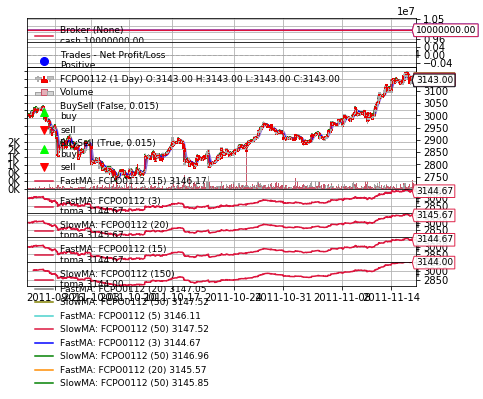

Starting Portfolio Value: 10000000.00
ind:tma, ma type:fast, period:3
ind:tma, ma type:slow, period:200
ind:ama, ma type:fast, period:3
ind:ama, ma type:slow, period:20
ind:tma, ma type:fast, period:15
ind:tma, ma type:slow, period:50
ind:tma, ma type:fast, period:5
ind:tma, ma type:slow, period:100
ind:ama, ma type:fast, period:20
ind:ama, ma type:slow, period:100
ind:tma, ma type:fast, period:10
ind:tma, ma type:slow, period:50
ind:tpma, ma type:fast, period:10
ind:tpma, ma type:slow, period:50
ind:sma, ma type:fast, period:3
ind:sma, ma type:slow, period:200
ind:ama, ma type:fast, period:15
ind:ama, ma type:slow, period:200
ind:tpma, ma type:fast, period:10
ind:tpma, ma type:slow, period:100
Rating:0.15135432707136978 and extent:H for key:FCPO0112_ama_3_20
Average rating:0.15135432707136978 and pos is:0 for key:FCPO0112_tpma_10_100
EXITING THE PROGRAM
Final Portfolio Value: 10000000.00


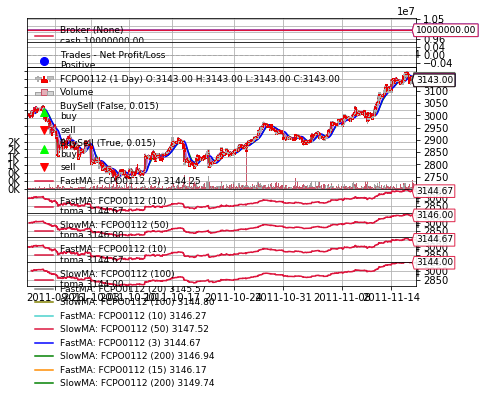

In [27]:
inds = ['tma']
m= [20]
n = [10] #[3,5,10,15,20] #skip 1

pop= generateRandomPopulation()
#for individual in pop.items():
    #individual = np.append(individual,["ST"])
#    print (individual)

pind = {'individual': [['tpma', '3', '10', 'EH', '0.1'],
       ['tma', '5', '150', 'EH', '0.9'],
       ['tpma', '5', '200', 'EL', '-0.30000000000000016'],
       ['tma', '10', '50', 'H', '0.30000000000000004'],
       ['tma', '15', '20', 'EH', '0.30000000000000004'],
       ['tpma', '3', '20', 'M', '-0.1000000000000002'],
       ['tma', '3', '50', 'EL', '-0.8'],
       ['ama', '15', '150', 'EL', '-0.1000000000000002'],
       ['sma', '20', '100', 'EH', '0.2'],
       ['ama', '20', '200', 'M', '-0.9']]}

#main(pind, bGetRating=True, plotFileName="TestRun")
#print (pind)
#print (pop[1])
i = 1
for ind in pop.values():
    #print (ind)
    main(ind, bGetRating=True, plotFileName="Run{}".format(i), bDebug=True)
    i = i+1
    
    #print(params[:,0],params[:,1], params[:,2], params[:,3], params[:,4])
#main(params[:,0],params[:,1], params[:,2], params[:,3], params[:,4])
#main(pop[1], bBestIndv=True)

5. Select the best individual in the training period. Calculate the trading volume using the initial capital and the rating degree. Then, calculate the rate of return according to the rate of return calculation method provided above. Every individual has a rate of return. The one that has the highest rate of return is the best individual in the training period.
1. Calculate the rate of return in the selection period using the best individual in the training period. Calculate the differences between the two moving averages of this selection period and the previous selection period. Then, obtain the membership function and calculate the rating level and the rate of return.
1. Mark the best individual. In the first cycle, mark the rate of return as the best rate of return and the best individual in the training period as the overall best individual. From the second cycle, compare the rate of return in this loop and the best rate of return. If the rate of return from this loop is higher than the best individual in the last loop, and the gap is over 0.05, replace the best rate of return and the overall best individual.

In [28]:
for ind in pop.values():
    print (ind['rating'])

max(d['rating'] for d in pop.values())

listOfKeys = [key  for (key, value) in pop.items() if value['rating'] == max(d['rating'] for d in pop.values())]
#print (listOfKeys)
bestIndividual = pop[listOfKeys[0]]
main(bestIndividual)

-0.025511696231374257
0.024427968998679273
0.08407349472160126
-8.23764347959531e-05
0.034301041156263
0.5578384865890416
0.14587496261612853
0.021411482989650638
0.00040314355266716703
0.08909615162490354
0.02605022029415546
0.19711155596274554
0.2625760167561425
0.16468340192667033
0.0549940055420268
0.2169097304174731
0.07682492819884004
0.03224257340500909
-0.00893219049081899
0.15135432707136978
Starting Portfolio Value: 10000000.00
2011-09-21, FCPO0112 BUY CREATE, 3030.00 with volume 23.00
2011-09-21, BUY EXECUTED, Size: 1841.05, Price: 3025.00, Cost: 7364204.44, Comm 11138.36, Portfolio Value: 10000000.00, Cash: 10000000.00
2011-09-21, FCPO0112 BUY CREATE, 3025.00 with volume 13.00
2011-09-21, Order Canceled/Margin/Rejected
2011-09-21, FCPO0112 BUY CREATE, 3027.00 with volume 20.00
2011-09-21, BUY EXECUTED, Size: 431.51, Price: 3030.00, Cost: 1726044.11, Comm 2614.96, Portfolio Value: 9992543.74, Cash: 2628339.30
2011-09-21, FCPO0112 BUY CREATE, 3030.00 with volume 3.00
2011-09-

In [ ]:
print (bestIndividual)

In [ ]:
print (pop[listOfKeys[0]])

1. Conduct a population evolution. Use genetic algorithms to choose 10% of the individuals from the old population in terms of their rate of return. Next, choose 80% of the individuals from the old population together with 10% randomly generated new individuals to experience the crossover and mutation. Finally, these two parts combined to form the new population.
1. Repeat Steps (4)–(6) for 50 repetitions. 
1. Calculate the rate of return of the best individual in the test period using the overall best individual selected in the previous steps. Calculate the two moving averages in this test period and the previous test period. Then, obtain the membership function and calculate the rating level and the rate of return.
1. Move forward to the next experiment period and return to step (1).